<a href="https://colab.research.google.com/github/alice202122/Thesis/blob/main/transferLearningFN_DEEPDATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from IPython.display import Image, display
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import cv2 #image operations

In [3]:
import pickle
import os
import random
import pandas as pd
import seaborn as sns
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from PIL import Image

from tensorflow.keras import layers, models, backend, applications, regularizers, initializers
from tensorflow.keras.layers import Layer

from tensorflow.python.ops import math_ops

from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from sklearn.utils import class_weight
from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, GlobalAveragePooling1D,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.8.2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
%cd /content/drive/MyDrive/Tesi

/content/drive/MyDrive/Tesi


In [105]:
 !unzip data_deep.zip

Archive:  data_deep.zip
replace data_deep/test/D_DEEP/1610_insalata_vincenza__661_Angio Retina_OD_2017-05-04_10-14-23_F_1945-07-19_Enface-304x304-Deep.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data_deep/test/D_DEEP/1610_insalata_vincenza__661_Angio Retina_OD_2017-05-04_10-14-23_F_1945-07-19_Enface-304x304-Deep.png  
  inflating: data_deep/test/D_DEEP/1616_de fabritiis_carla__710_Angio Retina_OS_2017-05-25_12-11-38_F_1928-01-30_Enface-304x304-Deep.png  
  inflating: data_deep/test/D_DEEP/1621_dibello_isabella__616_Angio Retina_OD_2017-03-30_09-42-37_F_1940-06-22_Enface-304x304-Deep.png  
  inflating: data_deep/test/D_DEEP/1621_dibello_isabella__616_Angio Retina_OS_2017-03-30_09-47-40_F_1940-06-22_Enface-304x304-Deep.png  
  inflating: data_deep/test/D_DEEP/1665_maselli_margherita__766_Angio Retina_OD_2017-07-13_10-56-36_F_1937-08-22_Enface-304x304-Deep.png  
  inflating: data_deep/test/D_DEEP/1665_maselli_margherita__766_Angio Retina_OS_2017-07-13_11-00-09_F_1937-08-22_E

In [106]:
dataset_dir = 'data_deep' #path to the folder
training_dir = 'data_deep/training' #we are putting together these string
validation_dir ='data_deep/validation'
test_dir = 'data_deep/test'


In [107]:
    
training = tf.keras.preprocessing.image_dataset_from_directory(
    training_dir, image_size=(304, 304), batch_size=32)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir, image_size=(304, 304), batch_size=32)
test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=(304, 304),shuffle= False, labels="inferred",
    label_mode="int",)


print(type(training))

Found 444 files belonging to 3 classes.
Found 111 files belonging to 3 classes.
Found 142 files belonging to 3 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [108]:

for data, labels in training.take(1):
    print(data.shape)
    print(labels.shape)

(32, 304, 304, 3)
(32,)


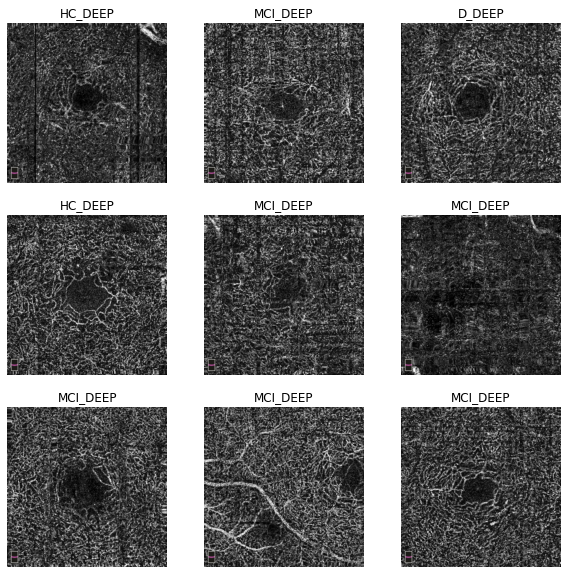

In [109]:
import matplotlib.pyplot as plt
 
class_names = training.class_names
plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

DENOISE FUNCTION DOES NOT WORK

In [ ]:
def denoise(img):
    '''remove noise from an image'''
    for images in training, validation, test:
      for img in images:
        img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    return img


##image data generator

In [110]:
from collections import Counter  
from keras.applications.vgg19 import VGG19, preprocess_input
im_gen= ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = im_gen.flow_from_directory(training_dir, 
                                      target_size=(304, 304),
                                      color_mode='rgb', 
                                      class_mode= 'categorical',   
                                      
                                    
                                      shuffle=True,
                                      seed=seed,)
counter = Counter(train_data.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

val_data = im_gen.flow_from_directory(validation_dir, 
                                      target_size=(304, 304),
                                      color_mode='rgb',    
                                      class_mode= 'categorical',   
                                      
                                      shuffle=True,
                                      seed=seed,)
test_data = im_gen.flow_from_directory(test_dir, 
                                      target_size=(304,304),
                                      color_mode='rgb',    
                                      class_mode= 'categorical',                                  
                                      
                                      
                                      shuffle=False,
                                      seed=seed,)

aug_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
    
    rotation_range=3,)

aug_train_data = aug_img_gen.flow_from_directory(training_dir,
                                                 target_size=(304, 304),
                                                  color_mode='rgb',    
                                                  class_mode= 'categorical',   
                                                  batch_size=32,
                                                  shuffle=True,
                                                  seed=seed,)
images, labels = next(aug_train_data)

print(images.shape)
print(labels.shape)
print(class_weights)

Found 444 images belonging to 3 classes.
Found 111 images belonging to 3 classes.
Found 142 images belonging to 3 classes.
Found 444 images belonging to 3 classes.
(32, 304, 304, 3)
(32, 3)
{0: 3.6615384615384614, 1: 1.6879432624113475, 2: 1.0}


In [111]:
#true test labels
y_true = test_data.classes

In [112]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [113]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [ layers.RandomRotation(0.01),]
)

In [114]:
input_shape= (304,304,3)
batch_size = 32

##multi class GEV ACTIVATION FUNCTION

In [ ]:
class GEV(Layer):
    def __init__(self,**kwargs):
        super(GEV, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(1,),
                                  initializer=tf.constant_initializer(0.),
                                  trainable=True,
                                  dtype='float32')
        self.sigma = self.add_weight(name='sigma',
                                     shape=(1,),
                                     initializer=tf.constant_initializer(1.),
                                     trainable=True,
                                     dtype='float32')
        self.xi = self.add_weight(name='xi',
                                  shape=(1,),
                                  initializer=tf.constant_initializer(0.),
                                  trainable=True,
                                  dtype='float32')
        super(GEV, self).build(input_shape)
 
    def call(self, x):

        sigma = backend.maximum(backend.epsilon(), self.sigma)  # sigma<0 doesn't make sense

        # Type 1: For xi = 0 (Gumbel)
        def t1(x=x, mu=self.mu, sigma=sigma):
            return backend.exp(-backend.exp(-(x-self.mu)/sigma))

        # Type 2: For xi>0 (Frechet) or xi<0 (Reversed Weibull) 
        def t23(x=x, mu=self.mu, sigma=sigma, xi=self.xi):
            y = (x - mu) / sigma
            y = xi*y
            y = tf.maximum(tf.constant(-1.), y)
            y = backend.exp(-tf.pow( tf.constant(1.) + y, -tf.constant(1.)/xi))        
            return y 

        GEV = tf.cond(backend.equal(tf.constant(0.), self.xi), t1, t23) # This chooses the type based on xi
        return GEV 

    def compute_output_shape(self, input_shape):
        return input_shape


class mGEV(Layer):

    def __init__(self, **kwargs):
        super(mGEV, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(input_shape[-1],),
                                  initializer=tf.constant_initializer(0.),
                                  trainable=True,
                                  dtype='float32')
        self.sigma = self.add_weight(name='sigma',
                                     shape=(input_shape[-1],),
                                     initializer=tf.constant_initializer(1.),
                                     trainable=True,
                                     dtype='float32')
        self.xi = self.add_weight(name='xi',
                                  shape=(1,),
                                  initializer=tf.constant_initializer(0.1),
                                  regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5),
                                  trainable=True,
                                  dtype='float32')
        super(mGEV, self).build(input_shape)
 
    def call(self, x):
        mu = backend.cast(self.mu, 'float32')
        sigma = backend.cast(self.sigma, 'float32')
        xi = backend.cast(self.xi, 'float32')
        x = backend.cast(x, 'float32')
        x = tf.clip_by_value(x, -20, 20) 

        sigma = backend.maximum(backend.epsilon(), sigma)
        

        # Type 1: For xi = 0 (Gumbel)
        def t1(x=x, mu=mu, sigma=sigma, xi=xi):
            return backend.exp(-backend.exp(-(x-mu)/sigma)) 

        # Type 2: For xi>0 (Frechet) or xi<0 (Reversed Weibull) 
        def t23(x=x, mu=mu, sigma=sigma, xi=xi):        
            y = (x - mu) / sigma
            y = xi*y
            tf.debugging.assert_all_finite(y, 'xi*y',name=None)
            y = tf.maximum(tf.constant(-1., dtype='float32'), y)
            y = backend.exp(-tf.pow( tf.constant(1., dtype='float32') + y, -tf.constant(1., dtype='float32')/xi))       
            return y 

        mGEV = tf.cond(backend.equal(tf.constant(0., dtype='float32'), backend.cast(xi, 'float32')), t1, t23) 
        mGEV = mGEV/tf.math.reduce_sum(mGEV)
        return mGEV 

    def compute_output_shape(self, input_shape):
        return input_shape
    


In [115]:
#this is a basic model to see the initial scores, without TL and FT
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    #input_layer= data_augmentation(inputs)

    #resize_layer = tfkl.Resizing(224, 224, interpolation="bicubic")(input_layer)

    conv1 = tfkl.Conv2D(
        filters=8,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        
        
        name = 'Conv1')(input_layer)
    act1= keras.layers.LeakyReLU(alpha=0.2)(conv1)
    pool1 = tfkl.MaxPooling2D(name = 'Pool1')(act1)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
       
        
        name = 'Conv2')(act1)
    act2= keras.layers.LeakyReLU(alpha=0.2)(conv2)
    pool2 = tfkl.MaxPooling2D(name = 'Pool1')(act2)

    
  
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(pool2)
    
    
    classifier_layer = tfkl.Dropout(0.4, seed=seed, name='ClassifierDropout')(glob_pooling)

    output_layer = tfkl.Dense(
        units=3, 
         kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),  
        name='Output')(classifier_layer)
    
    
    output_layer = tfkl.Dense(
       units=3, 
       kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation= 'softmax',
     name='Output')(classifier_layer)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy()],)

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 304, 304, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 304, 304, 8)       224       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 304, 304, 8)       0         
                                                                 
 Conv2 (Conv2D)              (None, 304, 304, 16)      1168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 304, 304, 16)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 152, 152, 16)      0         
                                                                 
 GlobalPooling (GlobalAverag  (None, 16)               0     

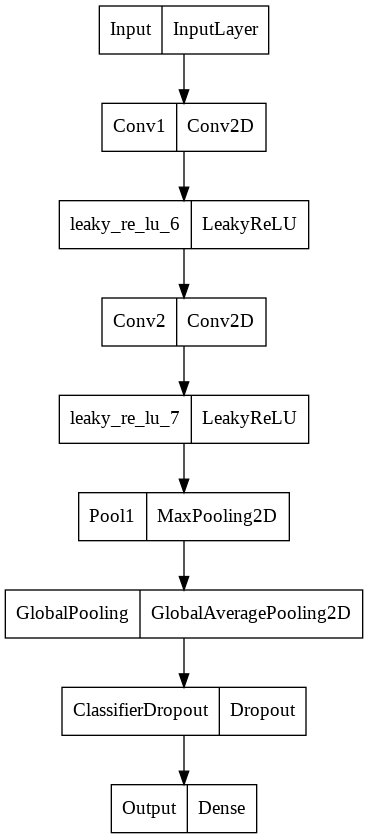

In [116]:
standard_model = build_model(input_shape)
standard_model.summary()
tfk.utils.plot_model(standard_model)



In [117]:
# Train the model
standard_history = standard_model.fit(
    aug_train_data, 
    batch_size = batch_size,
    epochs = 20,
    validation_data = val_data,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/20
14/14 [==============================] - 15s 1s/step - loss: 19.1186 - categorical_accuracy: 0.3941 - val_loss: 12.6718 - val_categorical_accuracy: 0.5405
Epoch 2/20
14/14 [==============================] - 14s 978ms/step - loss: 7.6981 - categorical_accuracy: 0.4459 - val_loss: 3.7754 - val_categorical_accuracy: 0.4685
Epoch 3/20
14/14 [==============================] - 11s 812ms/step - loss: 4.7513 - categorical_accuracy: 0.3446 - val_loss: 3.0291 - val_categorical_accuracy: 0.5405
Epoch 4/20
14/14 [==============================] - 11s 804ms/step - loss: 2.9097 - categorical_accuracy: 0.3919 - val_loss: 2.1699 - val_categorical_accuracy: 0.5315
Epoch 5/20
14/14 [==============================] - 12s 820ms/step - loss: 1.8386 - categorical_accuracy: 0.4392 - val_loss: 1.7424 - val_categorical_accuracy: 0.5405
Epoch 6/20
14/14 [==============================] - 11s 812ms/step - loss: 1.5405 - categorical_accuracy: 0.4572 - val_loss: 1.5619 - val_categorical_accuracy: 0.5315

In [118]:
y_pred_standard = standard_model.predict(test_data, batch_size=32, verbose=1)
y_pred_bool_standard = np.argmax(y_pred_standard, axis=1)

5/5 [==============================] - 1s 240ms/step


In [119]:
y_pred_bool_standard

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [120]:
from sklearn.metrics import classification_report

y_pred = standard_model.predict(test_data, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_bool))

5/5 [==============================] - 1s 203ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        45
           2       0.54      1.00      0.70        77

    accuracy                           0.54       142
   macro avg       0.18      0.33      0.23       142
weighted avg       0.29      0.54      0.38       142



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##TRANFER LEARNING

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

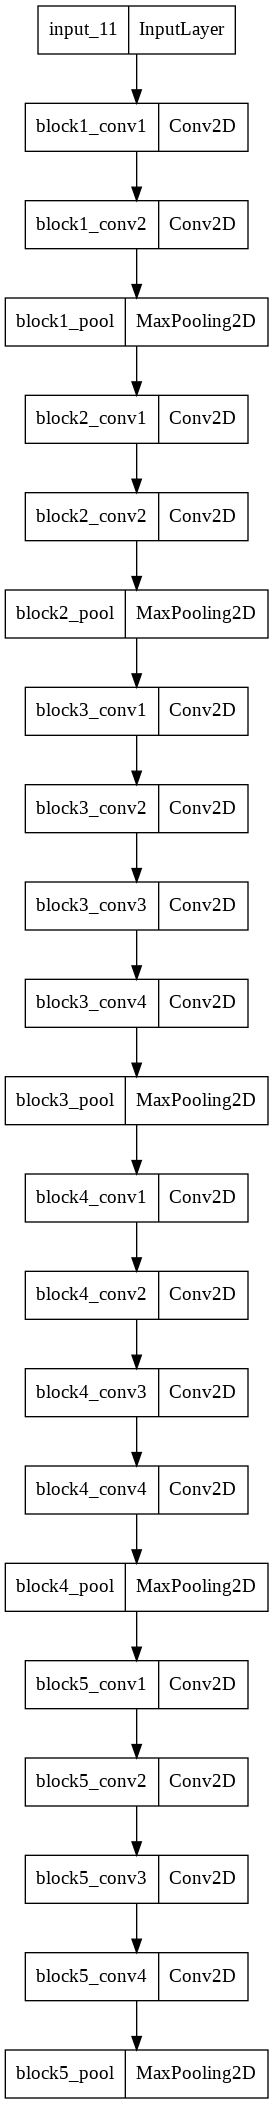

In [121]:
supernet = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [122]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(304,304,3))
x = tfkl.Resizing(224, 224, interpolation="bicubic")(inputs)
x= data_augmentation(x)
x = supernet(x)
#tried to insert a conv layer here, but even with only 8 units it makes the model overfit
x= keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
outputs = keras.layers.Dense(3, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation= 'softmax')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 304, 304, 3)]     0         
                                                                 
 resizing_6 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                             

In [123]:
# Train the model
tl_history = tl_model.fit(
    aug_train_data,
    batch_size = batch_size,
    epochs = 40,
    validation_data = val_data,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/40
14/14 [==============================] - 18s 1s/step - loss: 2.9790 - accuracy: 0.4144 - val_loss: 1.5607 - val_accuracy: 0.4865
Epoch 2/40
14/14 [==============================] - 12s 878ms/step - loss: 2.7905 - accuracy: 0.3896 - val_loss: 1.6822 - val_accuracy: 0.5225
Epoch 3/40
14/14 [==============================] - 12s 874ms/step - loss: 2.3454 - accuracy: 0.4077 - val_loss: 1.4448 - val_accuracy: 0.5315
Epoch 4/40
14/14 [==============================] - 12s 870ms/step - loss: 2.1861 - accuracy: 0.3941 - val_loss: 1.3549 - val_accuracy: 0.4505
Epoch 5/40
14/14 [==============================] - 12s 869ms/step - loss: 1.8717 - accuracy: 0.4302 - val_loss: 1.3552 - val_accuracy: 0.4414
Epoch 6/40
14/14 [==============================] - 14s 974ms/step - loss: 1.7511 - accuracy: 0.4032 - val_loss: 1.3387 - val_accuracy: 0.4505
Epoch 7/40
14/14 [==============================] - 12s 876ms/step - loss: 1.7900 - accuracy: 0.4279 - val_loss: 1.2738 - val_accuracy: 0.4414
Ep

In [125]:
# Save the best model
tl_model.save('TransferLearningModel1')

INFO:tensorflow:Assets written to: TransferLearningModel1/assets


##FINE TUNING

In [126]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel1')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 304, 304, 3)]     0         
                                                                 
 resizing_6 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                             

In [127]:
# Set all VGG layers to True
ft_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_11 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [128]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg19').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_11 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 304, 304, 3)]     0         
                                                                 
 resizing_6 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 


In [98]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




In [129]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-6), metrics=['accuracy',f1_m,precision_m, recall_m])

In [130]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_data,
    
    epochs = 40,
    validation_data = val_data,
    callbacks = [tfk.callbacks.EarlyStopping(monitor= 'val_loss', mode='max', patience=10, restore_best_weights=True)]
).history #here I monitor validation loss to monitor overfitting

Epoch 1/40
14/14 [==============================] - 8s 456ms/step - loss: 1.8796 - accuracy: 0.4685 - f1_m: 0.4660 - precision_m: 0.4753 - recall_m: 0.4573 - val_loss: 1.2835 - val_accuracy: 0.4955 - val_f1_m: 0.4890 - val_precision_m: 0.5042 - val_recall_m: 0.4760
Epoch 2/40
14/14 [==============================] - 5s 359ms/step - loss: 1.8525 - accuracy: 0.4392 - f1_m: 0.4325 - precision_m: 0.4472 - recall_m: 0.4190 - val_loss: 1.2173 - val_accuracy: 0.4685 - val_f1_m: 0.4323 - val_precision_m: 0.4480 - val_recall_m: 0.4182
Epoch 3/40
14/14 [==============================] - 5s 363ms/step - loss: 1.8056 - accuracy: 0.4212 - f1_m: 0.4070 - precision_m: 0.4233 - recall_m: 0.3922 - val_loss: 1.1701 - val_accuracy: 0.4775 - val_f1_m: 0.4470 - val_precision_m: 0.4679 - val_recall_m: 0.4281
Epoch 4/40
14/14 [==============================] - 5s 361ms/step - loss: 1.7240 - accuracy: 0.4032 - f1_m: 0.3903 - precision_m: 0.4126 - recall_m: 0.3712 - val_loss: 1.1417 - val_accuracy: 0.4595 - va

In [131]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = ft_model.evaluate(test_data)

5/5 [==============================] - 3s 594ms/step - loss: 1.3225 - accuracy: 0.4859 - f1_m: 0.5263 - precision_m: 0.5363 - recall_m: 0.5170


In [132]:
pred = ft_model.predict(test_data)
y_pred = np.argmax(pred,axis=1) 

In [133]:
y_pred

array([1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [136]:
from sklearn.metrics import classification_report
#support is the number of actual occurrences in the test set of those classes

y_pred = ft_model.predict(test_data, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_bool, digits= 5))
#DEMENTIA PATIENTS NEVER PREDICTED

5/5 [==============================] - 2s 310ms/step
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        20
           1    0.28571   0.17778   0.21918        45
           2    0.54464   0.79221   0.64550        77

    accuracy                        0.48592       142
   macro avg    0.27679   0.32333   0.28823       142
weighted avg    0.38588   0.48592   0.41948       142



#con il fine tuning il modello overfitta.

In [ ]:
import keras.backend as K

In [ ]:
y_pred

array([2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2])

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

##METRICS

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.SensitivityAtSpecificity( 0.5),
     
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#ROC-AUC

0= DEMENTIA: 3.7611940298507465,


1:HEALTHY CONTROL 1.8666666666666667,


2:MILD COGNITIVE IMPAIRMENT *1.0*

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [ ]:
pred = tl_model.predict(test_data)
pred = np.argmax(pred,axis=1) 

In [ ]:
pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
from sklearn import metrics

score = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.5625


In [ ]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = tl_model.predict(test_data)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(y_true, pred)
print("Log loss score: {}".format(score))

# raw probabilities to chosen class (highest probability)
pred = np.argmax(pred,axis=1) 

Numpy array of predictions


array([[ -9.1952,   5.1915,   8.1589],
       [ -6.7406,   5.1332,   7.2871],
       [ -7.662 ,   5.1716,   5.4001],
       [-10.1768,   4.9   ,   6.8564],
       [ -9.227 ,   5.4679,   9.3433]], dtype=float32)

As percent probability
[-919.5153  519.1454  815.8937]
Log loss score: 4.046270115507974


In [ ]:
prob_vector = ft_model.predict(test_data)[:, 1]

In [ ]:
prob_vector.shape

(144,)

In [ ]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [ ]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

Text(0, 0.5, 'True Positive Rate')

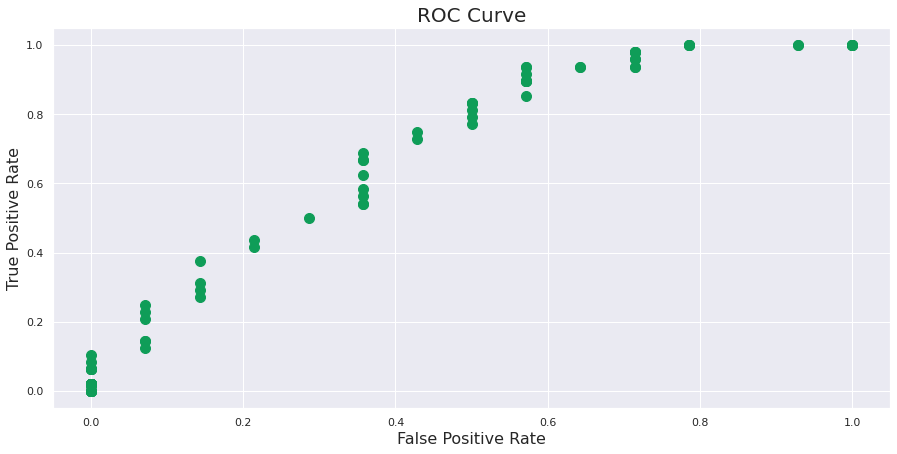

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
plt.figure(figsize=(15,7))

ROC = roc_from_scratch(prob_vector,y_true,partitions=100)
plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.title('ROC Curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)

In [ ]:
def create_triangle(tpr_0,tpr_1,fpr_0,fpr_1):
    plt.plot([tpr_0,tpr_1],[fpr_0,fpr_1], 'k-', lw=2,color='#4285F4')
    plt.plot([tpr_0,tpr_1],[fpr_1,fpr_1], 'k-', lw=2,color='#4285F4')
    plt.plot([tpr_0,tpr_0],[fpr_0,fpr_1], 'k-', lw=2,color='#4285F4')
    print('area: ',(tpr_0-tpr_1)*(fpr_0-fpr_1)/2)

def create_rectangle(tpr_0,fpr_0):
    plt.plot([tpr_0,tpr_0],[fpr_0,0], 'k-', lw=2,color='#4285F4')

In [ ]:
import pandas as pd
import numpy as np
partitions = 100
ROC = roc_from_scratch(prob_vector, y_true, partitions=partitions)
fpr, tpr = ROC[:, 0], ROC[:, 1]
rectangle_roc = 0
for k in range(partitions):
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
rectangle_roc

0.7202380952380951